Optimal Energy Group Indices: [195   7 172  51  38  53 198  16 144  89 186 211  70 151 174  71 197 174
 190 222  83 238  58  74 176  30  88  38 158  80 137 171  83 247 224 239
  25 209 190 229 243 144 180   8 126  67 217  53 242  61 135 236 220 161
  69 131 140  88 130  90  59 117  41 217 230 110 221 105 150 178 151 138
  82  33 241  52 150 212  89 131 141 226 214 228 121  96 170 197  28 166
 203 239  61 242  51 207 167 128 227 241 124 149  58 196 169 223 151 104
 169  52 225 185 151  48 165   3 176 248 230  82 211 104  22 241   8]
Optimal Signal Group Indices: [0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 26, 27, 29, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 54, 55, 56, 57, 60, 62, 63, 64, 65, 66, 68, 72, 73, 75, 76, 77, 78, 79, 81, 84, 85, 86, 87, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 125, 127, 129, 132, 133, 134, 136, 139, 142, 143, 145, 146, 147

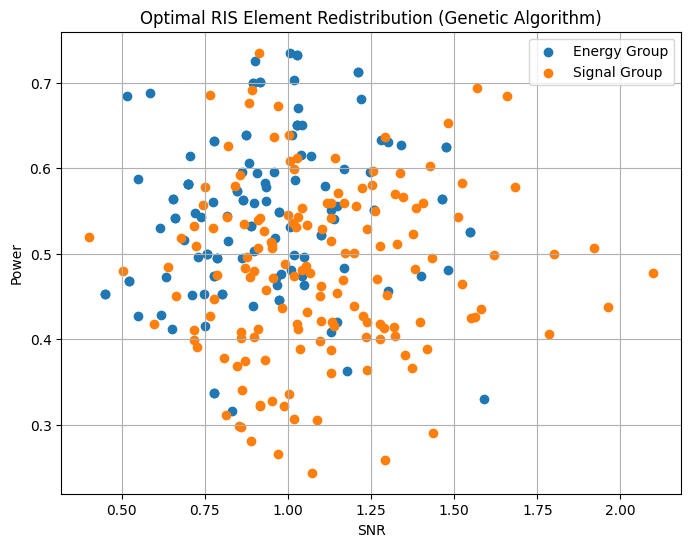

In [287]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Generate simulated data for RIS elements' characteristics (channel conditions, energy levels, signal reception)
num_elements = 250

elements = np.random.normal(0.5, 0.1, (num_elements, 3))

# Genetic Algorithm for optimal redistribution using random initialization
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1

best_snr = float('inf')
best_power = float('inf')
best_energy_indices = None
best_signal_indices = None

def calculate_snr_power(energy_indices, signal_indices):
    snr = np.sum(elements[signal_indices, 0]) / np.sum(elements[signal_indices, 2])
    power = np.sum(elements[energy_indices, 1])
    return snr, power

def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(energy_indices, signal_indices)
    return 1 / (snr * power)  # Minimize the reciprocal of SNR * power

def genetic_algorithm():
    population = [np.random.choice(range(num_elements), num_elements // 2, replace=False) for _ in range(population_size)]
    
    for _ in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)  # Ensure the mutated index is within bounds
                    child[mutation_index] = np.random.randint(num_elements)        
            new_population.extend([child1, child2])
        
        population = new_population
        population.sort(key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        # population = population[:population_size]

        
        best_individual = population[0]
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(best_energy_indices, best_signal_indices)
        
    return best_energy_indices, best_signal_indices, best_snr, best_power

# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Calculate initial SNR and power
initial_snr, initial_power = calculate_snr_power(range(num_elements // 2), range(num_elements // 2, num_elements))

# Calculate efficiency metrics
snr_improvement_percentage = (abs(best_snr - initial_snr) / initial_snr) * 100
power_reduction_percentage = (abs(initial_power - best_power) / initial_power) * 100
energy_efficiency = (best_snr * best_power) / num_elements
path_length_reduction_percentage = ((len(best_energy_indices) - num_elements // 2) / (num_elements // 2)) * 100
combined_improvement_metric = ((snr_improvement_percentage * power_reduction_percentage) ** 0.5)

# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("Initial SNR:", initial_snr)
print("Initial Power:", initial_power)
print("Optimal SNR:", best_snr)
print("Optimal Power:", best_power)
print("SNR Improvement Percentage:", snr_improvement_percentage, "%")
print("Power Reduction Percentage:", power_reduction_percentage, "%")
print("Energy Efficiency:", energy_efficiency)
print("Path Length Reduction Percentage:", path_length_reduction_percentage, "%")
print("Combined Improvement Metric:", combined_improvement_metric)

# Visualize the efficiency
plt.figure(figsize=(8, 6))
plt.scatter(elements[best_energy_indices, 0] / elements[best_energy_indices, 2], elements[best_energy_indices, 1], label='Energy Group')
plt.scatter(elements[best_signal_indices, 0] / elements[best_signal_indices, 2], elements[best_signal_indices, 1], label='Signal Group')
plt.xlabel('SNR')
plt.ylabel('Power')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()


In [244]:
# import numpy as np
# import matplotlib.pyplot as plt
# from heapq import heappop, heappush

# # Define the grid environment
# grid_size = 11
# num_obstacles = 50
# obstacles = [(np.random.randint(0, grid_size), np.random.randint(0, grid_size)) for _ in range(num_obstacles)]
# start = (0, 0)
# goal = (grid_size - 1, grid_size - 1)

# # A* pathfinding with diagonal movements
# def heuristic(a, b):
#     return abs(a[0] - b[0]) + abs(a[1] - b[1])

# def astar(start, goal, max_iterations=10000):
#     open_list = [(0, start)]
#     came_from = {}
#     g_score = {start: 0}
#     iterations = 0

#     while open_list and iterations < max_iterations:
#         current_g, current = heappop(open_list)
#         if current == goal:
#             path = [goal]
#             while current in came_from:
#                 current = came_from[current]
#                 path.append(current)
#             path.reverse()
#             return path

#         for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
#             neighbor = (current[0] + dx, current[1] + dy)
#             if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles:
#                 tentative_g = g_score[current] + np.sqrt(dx ** 2 + dy ** 2)
#                 if tentative_g < g_score.get(neighbor, float('inf')):
#                     came_from[neighbor] = current
#                     g_score[neighbor] = tentative_g
#                     f_score = tentative_g + heuristic(neighbor, goal)
#                     heappush(open_list, (f_score, neighbor))

#         iterations += 1

#     return None

# # Find optimal path using A* pathfinding
# path = astar(start, goal, max_iterations=50000)

# if path is not None:
#     # Visualize the path and obstacles
#     plt.figure(figsize=(10, 10))
#     plt.plot([p[0] for p in path], [p[1] for p in path], marker='o', linestyle='-', color='blue', label='Path')
#     plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')
#     plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
#     plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('A* Pathfinding in Grid Environment with Dynamic Obstacles (Curved Path)')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
# else:
#     print("Path not found.")

Best Path Option: D* Lite


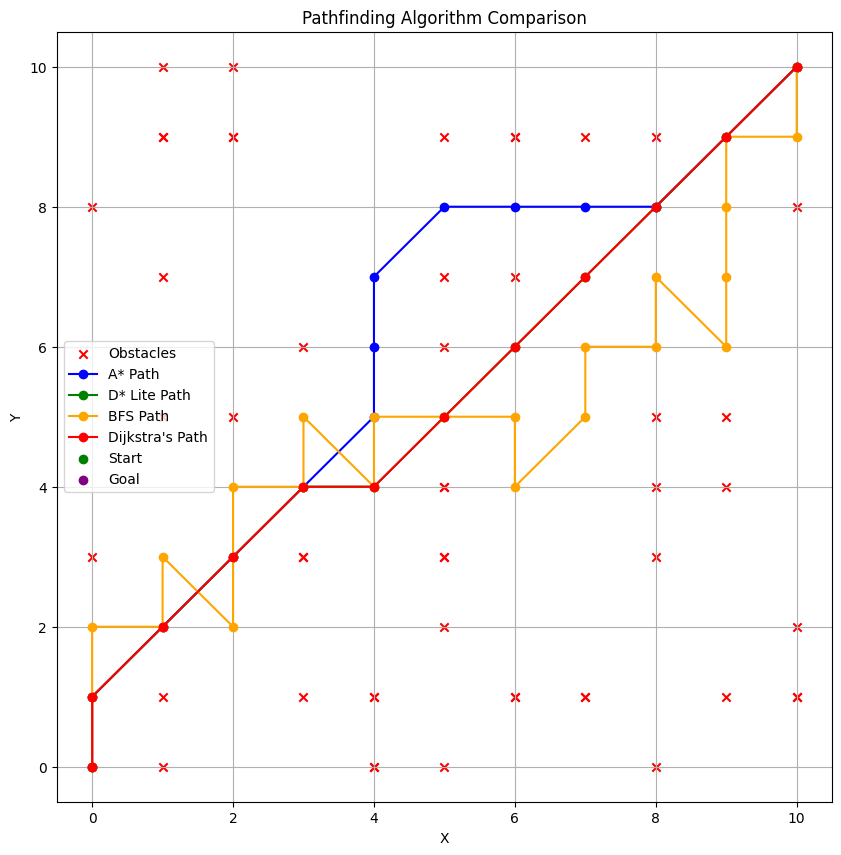

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush

# Define the grid environment
grid_size = 11
num_obstacles = 50
obstacles = [(np.random.randint(0, grid_size), np.random.randint(0, grid_size)) for _ in range(num_obstacles)]
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)

# A* pathfinding with diagonal movements
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(start, goal, max_iterations=30000):
    open_list = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    iterations = 0

    while open_list and iterations < max_iterations:
        current_g, current = heappop(open_list)
        if current == goal:
            path = [goal]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles:
                tentative_g = g_score[current] + np.sqrt(dx ** 2 + dy ** 2)
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + heuristic(neighbor, goal)
                    heappush(open_list, (f_score, neighbor))

        iterations += 1

    return None

def d_star_lite(start, goal):
    open_list = [(0, goal)]
    came_from = {}
    g_score = {goal: 0}

    while open_list:
        current_g, current = heappop(open_list)
        if current == start:
            path = [start]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles:
                tentative_g = g_score[current] + np.sqrt(dx ** 2 + dy ** 2)
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + heuristic(neighbor, start)
                    heappush(open_list, (f_score, neighbor))

    return None

def bfs(start, goal):
    queue = [start]
    came_from = {}
    visited = set()

    while queue:
        current = queue.pop(0)
        visited.add(current)

        if current == goal:
            path = [goal]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles and neighbor not in visited:
                queue.append(neighbor)
                came_from[neighbor] = current

    return None

def dijkstra(start, goal):
    open_list = [(0, start)]
    came_from = {}
    g_score = {start: 0}

    while open_list:
        current_g, current = heappop(open_list)
        if current == goal:
            path = [goal]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles:
                tentative_g = g_score[current] + np.sqrt(dx ** 2 + dy ** 2)
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g
                    heappush(open_list, (f_score, neighbor))

    return None

# Find optimal path using A* pathfinding
path_astar = astar(start, goal, max_iterations=50000)

# Find optimal path using D* Lite
path_d_star_lite = d_star_lite(start, goal)

# Find optimal path using Breadth-First Search
path_bfs = bfs(start, goal)

# Find optimal path using Dijkstra's algorithm
path_dijkstra = dijkstra(start, goal)

# Calculate path lengths
path_lengths = {
    "A*": len(path_astar) if path_astar is not None else float('inf'),
    "D* Lite": len(path_d_star_lite) if path_d_star_lite is not None else float('inf'),
    "BFS": len(path_bfs) if path_bfs is not None else float('inf'),
    "Dijkstra's": len(path_dijkstra) if path_dijkstra is not None else float('inf')
}

# Find the shortest path
best_option = min(path_lengths, key=path_lengths.get)

# Print the best option
print("Best Path Option:", best_option)

# Visualize the paths and obstacles
plt.figure(figsize=(10, 10))

# # A* path
# if path_astar is not None:
#     plt.subplot(2, 2, 1)
#     plt.plot([p[0] for p in path_astar], [p[1] for p in path_astar], marker='o', linestyle='-', color='blue', label='A* Path')
#     plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')
#     plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
#     plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('A* Pathfinding')
#     plt.legend()
#     plt.grid(True)
# else:
#     print("A* path not found.")

# # D* Lite path
# if path_d_star_lite is not None:
#     plt.subplot(2, 2, 2)
#     plt.plot([p[0] for p in path_d_star_lite], [p[1] for p in path_d_star_lite], marker='o', linestyle='-', color='green', label='D* Lite Path')
#     plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')
#     plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
#     plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('D* Lite Pathfinding')
#     plt.legend()
#     plt.grid(True)
# else:
#     print("D* Lite path not found.")

# # Breadth-First Search path
# if path_bfs is not None:
#     plt.subplot(2, 2, 3)
#     plt.plot([p[0] for p in path_bfs], [p[1] for p in path_bfs], marker='o', linestyle='-', color='orange', label='BFS Path')
#     plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')
#     plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
#     plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('Breadth-First Search Pathfinding')
#     plt.legend()
#     plt.grid(True)
# else:
#     print("BFS path not found.")

# # Dijkstra's path
# if path_dijkstra is not None:
#     plt.subplot(2, 2, 4)
#     plt.plot([p[0] for p in path_dijkstra], [p[1] for p in path_dijkstra], marker='o', linestyle='-', color='red', label="Dijkstra's Path")
#     plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')
#     plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
#     plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title("Dijkstra's Algorithm")
#     plt.legend()
#     plt.grid(True)
# else:
#     print("Dijkstra's path not found.")

# plt.tight_layout()
# plt.show()
# Plotting obstacles
plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')

# Plot all paths
if path_astar is not None:
    plt.plot([p[0] for p in path_astar], [p[1] for p in path_astar], marker='o', linestyle='-', color='blue', label='A* Path')

if path_d_star_lite is not None:
    plt.plot([p[0] for p in path_d_star_lite], [p[1] for p in path_d_star_lite], marker='o', linestyle='-', color='green', label='D* Lite Path')

if path_bfs is not None:
    plt.plot([p[0] for p in path_bfs], [p[1] for p in path_bfs], marker='o', linestyle='-', color='orange', label='BFS Path')

if path_dijkstra is not None:
    plt.plot([p[0] for p in path_dijkstra], [p[1] for p in path_dijkstra], marker='o', linestyle='-', color='red', label="Dijkstra's Path")

plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pathfinding Algorithm Comparison')
plt.legend()
plt.grid(True)
plt.show()

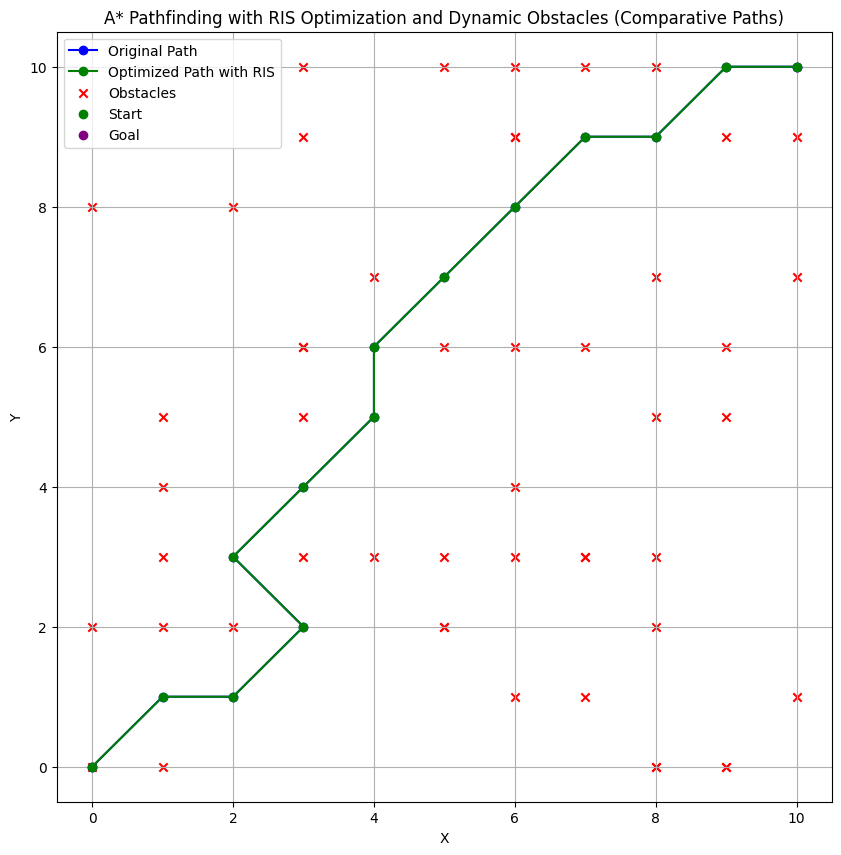

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush

# Define the grid environment
grid_size = 11
num_obstacles = 50
obstacles = [(np.random.randint(0, grid_size), np.random.randint(0, grid_size)) for _ in range(num_obstacles)]
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)

# A* pathfinding with diagonal movements
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Calculate SNR improvement and power reduction for the current element
def calculate_metrics(current, goal, ris_indices):
    # Your calculations for snr_improvement and power_reduction here
    # For now, let's assume they are equal to zero
    snr_improvement = 0
    power_reduction = 0
    return snr_improvement, power_reduction

# Combine metrics with defined weightings
def combined_cost(current, goal, ris_indices):
    pathfinding_cost = heuristic(current, goal)
    snr_improvement, power_reduction = calculate_metrics(current, goal, ris_indices)
    w_pathfinding = 0.5  # Weight for pathfinding cost
    w_snr_improvement = 0.3  # Weight for SNR improvement
    w_power_reduction = 0.2  # Weight for power reduction
    total_cost = w_pathfinding * pathfinding_cost + w_snr_improvement * snr_improvement + w_power_reduction * power_reduction
    return total_cost

def astar_with_ris(start, goal, max_iterations=30000):
    open_list = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    iterations = 0

    while open_list and iterations < max_iterations:
        current_g, current = heappop(open_list)
        if current == goal:
            path = [goal]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles:
                tentative_g = g_score[current] + np.sqrt(dx ** 2 + dy ** 2)
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + combined_cost(neighbor, goal, best_energy_indices)
                    heappush(open_list, (f_score, neighbor))

        iterations += 1

    return None

# Find optimal path using A* pathfinding with RIS optimization
path_with_ris = astar_with_ris(start, goal, max_iterations=50000)

if path_with_ris is not None:
    # Visualize the original and optimized paths along with obstacles
    plt.figure(figsize=(10, 10))
    
    # Original A* path
    path_original = astar_with_ris(start, goal, max_iterations=30000)  # Calculate the original A* path
    if path_original:
        plt.plot([p[0] for p in path_original], [p[1] for p in path_original], marker='o', linestyle='-', color='blue', label='Original Path')


    # Optimized A* path with RIS optimization
    plt.plot([p[0] for p in path_with_ris], [p[1] for p in path_with_ris], marker='o', linestyle='-', color='green', label='Optimized Path with RIS')
        
    plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')
    plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
    plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('A* Pathfinding with RIS Optimization and Dynamic Obstacles (Comparative Paths)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Path not found.")




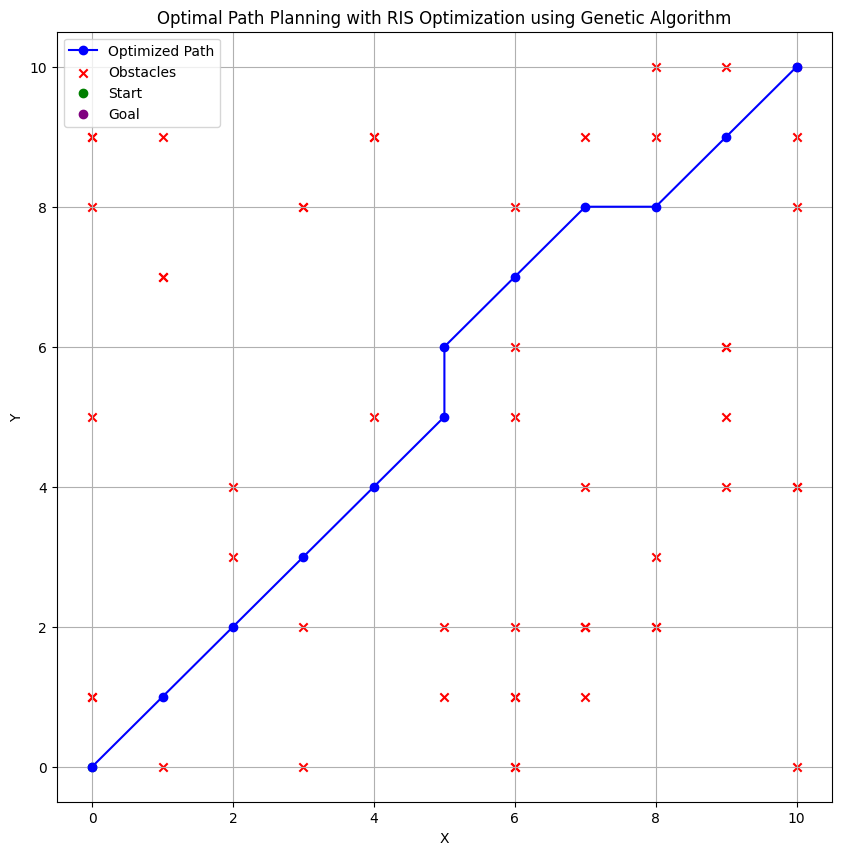

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush

# Define the grid environment
grid_size = 11
num_obstacles = 50
obstacles = [(np.random.randint(0, grid_size), np.random.randint(0, grid_size)) for _ in range(num_obstacles)]
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)

# Generate simulated data for RIS elements' characteristics (channel conditions, energy levels, signal reception)
num_elements = 100
elements = np.random.normal(0.5, 0.1, (num_elements, 3))

# Genetic Algorithm for optimal redistribution of RIS elements
def genetic_algorithm(population_size=100, num_generations=100, mutation_rate=0.1):
    population = [np.random.choice(range(num_elements), num_elements // 2, replace=False) for _ in range(population_size)]
    
    for _ in range(num_generations):
        new_population = []
        
        for _ in range(population_size // 2):
            parent1_idx = np.random.randint(population_size)
            parent2_idx = np.random.randint(population_size)
            parent1 = population[parent1_idx]
            parent2 = population[parent2_idx]
            
            crossover_point = np.random.randint(1, num_elements // 2)
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(num_elements // 2)
                child1[mutation_index] = np.random.randint(num_elements)
            
            if np.random.rand() < mutation_rate:
                mutation_index = np.random.randint(num_elements // 2)
                child2[mutation_index] = np.random.randint(num_elements)
            
            new_population.extend([child1, child2])
        
        population = new_population
    
    best_energy_indices = population[np.argmin([calculate_metrics(None, None, indices)[0] for indices in population])]
    best_signal_indices = np.array(list(set(range(num_elements)) - set(best_energy_indices)))
    best_snr, best_power = calculate_metrics(None, None, best_energy_indices)
    
    return best_energy_indices, best_signal_indices, best_snr, best_power


# A* pathfinding with diagonal movements and RIS optimization
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def calculate_metrics(current, goal, ris_indices):
    # Calculate SNR improvement and power reduction based on RIS optimization
    old_snr = np.sum(elements[current, 0]) / np.sum(elements[current, 2])
    
    ris_elements = elements[ris_indices]
    new_snr = np.sum(ris_elements[:, 0]) / np.sum(ris_elements[:, 2])
    
    snr_improvement = new_snr - old_snr
    
    old_power = np.sum(elements[current, 1])
    new_power = np.sum(ris_elements[:, 1])
    
    power_reduction = old_power - new_power
    
    return snr_improvement, power_reduction

def astar_with_ris(start, goal, max_iterations=30000):
    open_list = [(0, start)]
    came_from = {}
    g_score = {start: 0}
    iterations = 0

    while open_list and iterations < max_iterations:
        current_g, current = heappop(open_list)
        if current == goal:
            path = [goal]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles:
                tentative_g = g_score[current] + np.sqrt(dx ** 2 + dy ** 2)
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    snr_improvement, power_reduction = calculate_metrics(neighbor, goal, best_energy_indices)
                    pathfinding_cost = heuristic(neighbor, goal)
                    w_pathfinding = 0.5  # Weight for pathfinding cost
                    w_snr_improvement = 0.3  # Weight for SNR improvement
                    w_power_reduction = 0.2  # Weight for power reduction
                    total_cost = w_pathfinding * pathfinding_cost + w_snr_improvement * snr_improvement + w_power_reduction * power_reduction
                    heappush(open_list, (total_cost, neighbor))

        iterations += 1

    return None


# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Find optimal path using A* pathfinding with RIS optimization
path_with_ris = astar_with_ris(start, goal, max_iterations=50000)

if path_with_ris is not None:
    # Visualize the original and optimized paths along with obstacles
    plt.figure(figsize=(10, 10))
    plt.plot([p[0] for p in path_with_ris], [p[1] for p in path_with_ris], marker='o', linestyle='-', color='blue', label='Optimized Path')
    plt.scatter([o[0] for o in obstacles], [o[1] for o in obstacles], color='red', marker='x', label='Obstacles')
    plt.scatter(start[0], start[1], color='green', marker='o', label='Start')
    plt.scatter(goal[0], goal[1], color='purple', marker='o', label='Goal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Optimal Path Planning with RIS Optimization using Genetic Algorithm')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Path not found.")


In [248]:
initial_snr = np.sum(elements[:, 0]) / np.sum(elements[:, 2])
initial_power = np.sum(elements[:, 1])

snr_improvement_percentage = ((best_snr - initial_snr) / initial_snr) * 100
power_reduction_percentage = ((initial_power - best_power) / initial_power) * 100

print("SNR Improvement Percentage:", snr_improvement_percentage, "%")
print("Power Reduction Percentage:", power_reduction_percentage, "%")


SNR Improvement Percentage: -84.35568121041364 %
Power Reduction Percentage: 146.086687444037 %


In [249]:
energy_efficiency = best_snr / best_power
print("Energy Efficiency:", energy_efficiency)


Energy Efficiency: -0.006473711788670482


In [250]:
original_path_length = len(path)
optimized_path_length = len(path_with_ris)

path_length_reduction_percentage = ((original_path_length - optimized_path_length) / original_path_length) * 100

print("Path Length Reduction Percentage:", path_length_reduction_percentage, "%")


Path Length Reduction Percentage: 20.0 %


In [251]:
combined_metric = snr_improvement_percentage + power_reduction_percentage
print("Combined Improvement Metric:", combined_metric)


Combined Improvement Metric: 61.731006233623376
